In [23]:

import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
from utils import *
from modules import UNet_conditional, EMA
import logging
from torch.utils.tensorboard import SummaryWriter

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")
"""
需要修改的地方：
1:把label换成image encoder，后续可能换成transformer
5:改进guidance的方式(corss attention)
7:加上实际的评价指标
11:修改部分
14:每100个epoch 一次所有数据
15:使用相邻slice做guidance
16:sample之后重新变成图片这一步可能有问题，不是直接归一化，可以用其他操作
17:sample之后加一个inpaint，输出图像
18:sample之后计算指标
19:
"""

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=240, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def _timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        # model.train()
        # x = (x.clamp(-1, 1) + 1) / 2
        # x = (x * 255).type(torch.uint8)
        return x

def inpaint_image(original_image, generated_image, mask):
    """
    将生成的图像融合到原始图像的指定区域中。
    
    参数:
    original_image (torch.Tensor): 原始图像
    generated_image (torch.Tensor): 生成的图像
    mask (torch.Tensor): 掩码图像, 1表示需要inpaint的区域, 0表示保留原图
    
    返回:
    torch.Tensor: 输出的合成图像
    """
    # 将三个输入tensor转换到相同的设备上
    device = original_image.device
    mask = mask.to(device)
    generated_image = generated_image.to(device)
    
    # 使用掩码融合原图和生成的图像
    output_image = original_image.clone()
    # print(output_image.shape, mask.shape, generated_image.shape)
    output_image = output_image * (1 - mask) + generated_image * mask
    
    return output_image


def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    test_dataloader = get_test_data(args)
    model = UNet_conditional().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    # for epoch in range(args.epochs):
    #     logging.info(f"Starting epoch {epoch}:")
    #     pbar = tqdm(dataloader)
    #     for i, (images, cropped_images, masks) in enumerate(pbar):
    #         # print(images.shape)
    #         # images = images.to(device)
    #         labels = cropped_images
    #         b, c, l, w = images.shape

    #         images_predict = torch.zeros_like(images)
    #         noise_predict = torch.zeros_like(images)

    #         # print(slice) #size 应该是 b, 1, 240, 240
    #         images_slice = images[:,:,:,:]
    #         labels_slice = labels[:,:,:,:]
    #         #去掉一个维度

    #         images_slice = images_slice.to(device)
    #         labels_slice = labels_slice.to(device)
    #         images_slice = images_slice.to(torch.float)
    #         labels_slice = labels_slice.to(torch.float)
    #         # print('input shape', images_slice.shape)


    #         t = diffusion._timesteps(images_slice.shape[0]).to(device)
    #         x_t, noise = diffusion.noise_images(images_slice, t)
    #         predicted_noise = model(x_t, t, labels_slice)
    #         images_predict[:,:,:,:] = predicted_noise
    #         noise_predict[:,:,:,:] = noise
    #         images_predict_slice = inpaint_image(images[:,:,:,:], images_predict[:,:,:,:], masks[:,:,:,:])
    #         noise_predict_slice = inpaint_image(images[:,:,:,:], noise_predict[:,:,:,:], masks[:,:,:,:])
    #         loss = mse(noise_predict_slice, images_predict_slice)

    #         optimizer.zero_grad()
    #         loss.backward()
    #         optimizer.step()
    #         ema.step_ema(ema_model, model)

    #         pbar.set_postfix(MSE=loss.item())
    #         logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        
        # images, cropped_images, masks = next(iter(pbar))
        # b, _, _, _ = images.shape
        # print('batch size:', b)
        # d_images = diffusion.(model, n=b, labels=cropped_images)
        # print(d_images.shape)
        # # ema_d_images = diffusion.(ema_model, n=b, labels=cropped_images)
        # # plot_images(d_images)
        # save_images(d_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        # # save_images(ema_d_images, os.path.join("results", args.run_name, f"{epoch}_ema.jpg"))
        # torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))
        # torch.save(ema_model.state_dict(), os.path.join("models", args.run_name, f"ema_ckpt.pt"))
        # torch.save(optimizer.state_dict(), os.path.join("models", args.run_name, f"optim.pt"))
    





import argparse
parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()
args.run_name = "DDPM_conditional"
args.epochs = 500
args.batch_size = 70
args.image_size = 96#这个参数有什么用，和原始图像的关系是什么
# args.dataset_path =  r"D:\ASNR-MICCAI-BraTS2023-Local-Synthesis-Challenge-Training"
args.dataset_path =  r"C:\Users\DELL\Desktop\DDPM\ddpm_brats\DDPM_brain\test_data"
args.device = "cuda"
args.lr = 3e-4
args.train = True
args.shuffle = False
device = 'cuda'
dataloader = get_data(args)
model = UNet_conditional().to(device)
ckpt = torch.load("./models/DDPM_conditional/ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=args.image_size, device=device)
pbar = tqdm(dataloader)
images, cropped_images, masks = next(iter(pbar))
b, _, _, _ = images.shape
d_images = diffusion.sample(model, n=b, labels=cropped_images)




  0%|          | 0/2 [00:00<?, ?it/s]
04:31:54 - INFO: Sampling 70 new images....
999it [08:30,  1.96it/s]


In [41]:
def inpaint_image(original_image, generated_image, mask):
    """
    将生成的图像融合到原始图像的指定区域中。
    
    参数:
    original_image (torch.Tensor): 原始图像
    generated_image (torch.Tensor): 生成的图像
    mask (torch.Tensor): 掩码图像, 1表示需要inpaint的区域, 0表示保留原图
    
    返回:
    torch.Tensor: 输出的合成图像
    """
    # 将三个输入tensor转换到相同的设备上
    device = original_image.device
    mask = mask.to(device)
    generated_image = generated_image.to(device)
    
    # 使用掩码融合原图和生成的图像
    output_image = original_image.clone()
    print(output_image.shape, mask.shape, generated_image.shape)
    # print(output_image.shape, mask.shape, generated_image.shape)
    reference_image = output_image * mask
    output_image = output_image * (1 - mask) + generated_image * mask
    generated_image = generated_image * mask
    
    return output_image, generated_image, reference_image
images_predict_slice, generated_image, reference_image = inpaint_image(images[:,:,:,:], d_images[:,:,:,:], masks[:,:,:,:])


torch.Size([70, 1, 96, 96]) torch.Size([70, 1, 96, 96]) torch.Size([70, 1, 96, 96])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
g_img 中包含非0元素
tensor([2.9880, 3.0152, 3.0300, 3.0456, 3.0237, 3.0197, 3.0084, 3.0257, 3.0415,
        3.0318, 3.0238, 3.0349, 3.0333, 3.0240, 3.0701, 3.0159, 3.0252, 3.0612,
        3.0211, 3.0659, 3.0542, 3.0463, 3.0299])


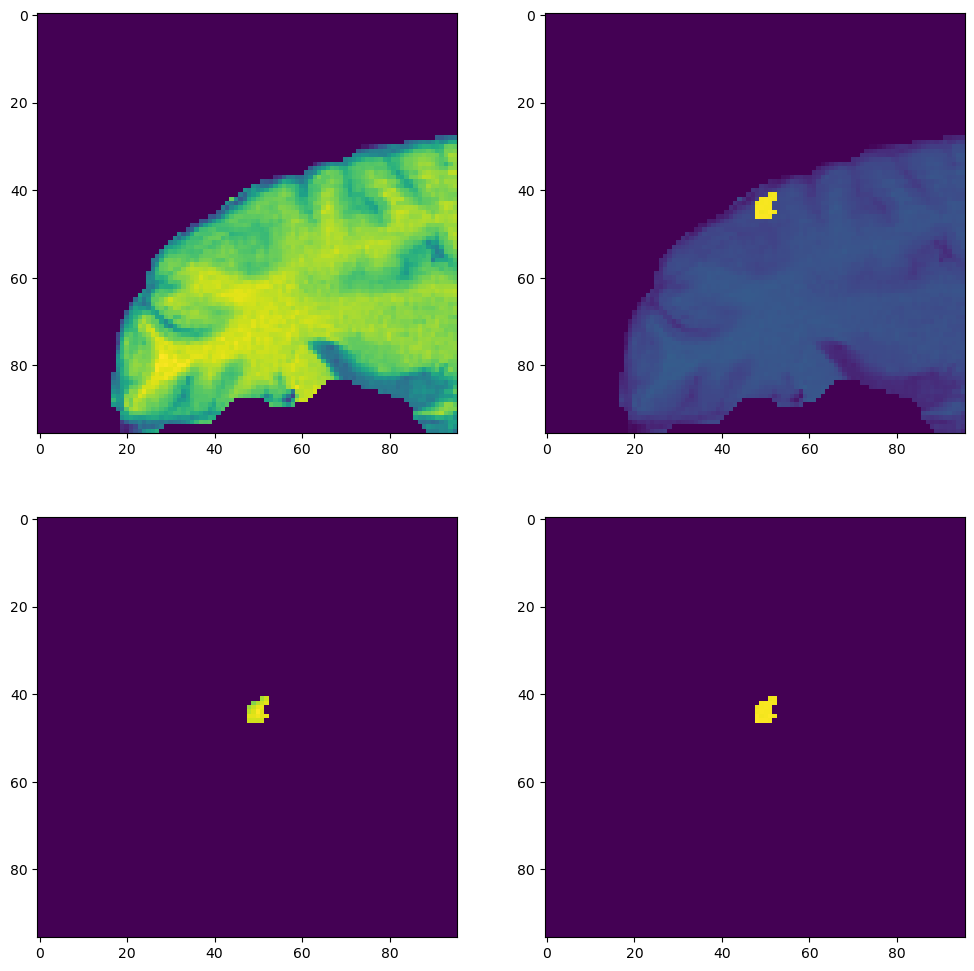

<Figure size 800x800 with 0 Axes>

tensor(0.0001)


In [47]:
import torch
import matplotlib.pyplot as plt



# 选择要显示的图像索引
index = 49
images = images.cpu()
d_images = images_predict_slice.cpu()
cropped_images = cropped_images.cpu()
g_images = generated_image.cpu()
r_images = reference_image.cpu()
masks_clone = masks.clone().cpu()
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# 获取选中的图像
img = images[index, 0, :, :]
d_img = d_images[index, 0, :, :]
c_img = cropped_images[index, 0, :, :]
g_img = g_images[index, 0, :, :]
r_img = r_images[index, 0, :, :]
print(g_img)
if torch.any(g_img != 0):
    print("g_img 中包含非0元素")
else:
    print("g_img 中全是0")
non_zero_elements = g_img[g_img != 0]
print(non_zero_elements)
# 使用 matplotlib 显示图像
plt.figure(figsize=(8, 8))
axes[0,0].imshow(img)
axes[0,1].imshow(d_img)
axes[1,0].imshow(r_img)
axes[1,1].imshow(g_img)
plt.show()
mse = nn.MSELoss()
loss = mse(reference_image, masks_clone)
print(loss)